In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 30.0 MB/s 
     |████████████████████████████████| 462 kB 39.2 MB/s 


In [3]:
import numpy as np
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Dataset

In [4]:
import pandas as pd
data = pd.read_excel("/content/drive/MyDrive/Mestrado/Datasets/oportunidades_classificacao_4.xlsx", sheet_name='Oportunidades')

In [ ]:
import requests
import pandas as pd
url = 'https://github.com/chap0lin/nlp_datasets/blob/master/oportunidades_classificacao_4.xlsx?raw=true'
r = requests.get(url)
open('temp.xlsx', 'wb').write(r.content)
data = pd.read_excel('temp.xlsx', sheet_name='Oportunidades')

In [5]:
print(data.shape)
data.sample(5)

(357, 11)


,opo_titulo,link,opo_texto,opo_texto_ele,opo_brazil,opo_tipo,opo_deadline,codigo,atualizacao,clas,comentario
131,Call for concept notes: Collaborative One Heal...,https://www.idrc.ca/en/funding/call-concept-no...,Call for concept notes: Collaborative One Hea...,Eligibility Eligible projects will be underta...,N,Grant,"Monday, April 5, 2021 - 23:00\n",irdc_210429_01_005,210429,Y,0
253,Audio Target Calibration and Localisation in A...,https://euraxess.ec.europa.eu//jobs/funding/au...,Outline Beyond the initial benefit to the gene...,Outline Beyond the initial benefit to the gene...,N,other,Applications accepted all year round,euraxess_210602_1_050,210602,NaN,NÃO FOI POSSIVEL DETERMINAR
83,Bolsa de PD em Biologia Estrutural e Descobert...,http://fapesp.br/oportunidades/Control/../cent...,The Center for Research and Innovation in Biod...,The Center for Research and Innovation in Biod...,Y,scholarship,10/05/2021,fapesp_210429_1_013,210429,Y,0
230,PhD Grant : Influence of manual activities on ...,https://euraxess.ec.europa.eu//jobs/funding/ph...,Scientific context and state of the art. For t...,Scientific context and state of the art. For t...,N,other,04/06/2021,euraxess_210602_1_027,210602,NaN,NÃO FOI POSSIVEL DETERMINAR
345,2021 Open Call for Shipboard Fellowship,http://www.oceantrainingpartnership.org/openca...,General Information 16 Feb 2021 to 30 Nov 2021...,This fellowship program is open to early caree...,Y,fellowship,30 Nov 2021,oceantrainingpartnership_210525_1_000,210525,Y,NaN


In [6]:
data['clas'].value_counts()

Y    152
N    108
Name: clas, dtype: int64

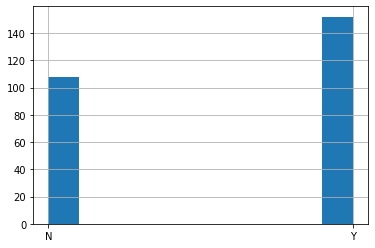

In [7]:
data['clas'].hist()

In [8]:
sentences = data['opo_texto']
labels = data['clas']

In [9]:
print(len(sentences), " - ", len(labels))

357  -  357


In [36]:
newdata = data.copy()
# subSampleBalanced.drop(subSampleBalanced[subSampleBalanced['category'] == 'business'].sample(frac=0.9).index)
# newdata = newdata.drop(newdata[newdata['clas'] != 'Y' or newdata['clas'] != 'N'].index)
# df[(df.line_race != 0) & (df.line_race != 10)]
newdata = newdata[(newdata['clas'] == 'Y') | (newdata['clas'] == 'N')]
sentences = newdata['opo_texto']
labels = newdata['clas']
print(len(sentences), " - ", len(labels))

260  -  260


In [14]:
print(classification_report(newdata['opo_brazil'], newdata['clas']))

              precision    recall  f1-score   support

           N       0.94      0.67      0.78       151
           Y       0.67      0.94      0.78       109

    accuracy                           0.78       260
   macro avg       0.80      0.80      0.78       260
weighted avg       0.82      0.78      0.78       260



In [12]:
labels = np.where(labels == "Y", 1, 0)

In [37]:
new_labels = []
for l in labels:
  if l == "Y":
    new_labels.append(1)
  else:
    new_labels.append(0)

## Pré-processamento / Text Normalization

In [42]:
print(sentences[0])
uncased_sentences = []
for s in sentences:
  uncased_sentences.append(s.lower())
print(uncased_sentences[0])

 gender-cfp-2021.jpg Caption: Interviewing a community member in Lao PDR.Credit: © FISHBIO Call for Proposals Development of an Innovative Knowledge Product Pertaining to the Strengthening of Women’s Voices in Conservation Opening Date: 22 March 2021Closing Date: 30 April 2021Questions Due Date: 15 April 2021Submissions: Applications should be sent to cepf@cepf.net by the closing date. Overview CEPF intends to engage a consultant to develop a knowledge product that will provide guidance on how to strengthen women’s voices in conservation.  More Information Call for Proposals- English (PDF - 238 KB)  
 gender-cfp-2021.jpg caption: interviewing a community member in lao pdr.credit: © fishbio call for proposals development of an innovative knowledge product pertaining to the strengthening of women’s voices in conservation opening date: 22 march 2021closing date: 30 april 2021questions due date: 15 april 2021submissions: applications should be sent to cepf@cepf.net by the closing date. ove

## Feature Engineering

### Train Test Split

In [43]:
x_train, x_test, y_train, y_test = train_test_split(uncased_sentences, new_labels, test_size=0.20, random_state=32)

In [ ]:
y_train

BERT

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [52]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    print(preprocessed_text.keys())
    return bert_encoder(preprocessed_text)['pooled_output']

e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

dict_keys(['input_word_ids', 'input_type_ids', 'input_mask'])


In [ ]:
cosine_similarity([e[0]],[e[1]]) #banana vs grapes

array([[0.9911088]], dtype=float32)

In [ ]:
cosine_similarity([e[0]],[e[3]]) #banana vs jeff bezos

array([[0.84703815]], dtype=float32)

In [ ]:
cosine_similarity([e[3]],[e[4]]) #jeff bezos vs elon musk

array([[0.9872035]], dtype=float32)

In [49]:
complete_e = get_sentence_embeding([
                                    "technology and computers and internet and stuff",
                                    "global warming and politics and government"
])

In [51]:
print(e)

tf.Tensor(
[[-0.7606915  -0.1421937   0.4960466  ...  0.42165384 -0.5322138
   0.8031215 ]
 [-0.86023194 -0.2124292   0.4915692  ...  0.3979806  -0.6050627
   0.84471625]
 [-0.7128859  -0.15463899  0.38401714 ...  0.35278752 -0.50991327
   0.73474073]
 [-0.825335   -0.3555061  -0.5906975  ... -0.0161376  -0.614176
   0.872303  ]
 [-0.7504133  -0.26812607 -0.26689577 ...  0.02839464 -0.5938097
   0.7974988 ]
 [-0.7854434  -0.29949653  0.41027546 ...  0.52225477 -0.4957353
   0.8150746 ]], shape=(6, 768), dtype=float32)


In [50]:
print(complete_e)

tf.Tensor(
[[-0.8243982  -0.5750423  -0.98420995 ... -0.90654814 -0.7589667
   0.9211425 ]
 [-0.8863488  -0.56693685 -0.92656666 ... -0.82211477 -0.689943
   0.78401893]], shape=(2, 768), dtype=float32)


Calculando vocab size

In [ ]:
alltext = ""
for s in x_train:
  alltext+= s
for s in x_test:
  alltext+= s

vocab = nltk.word_tokenize(alltext)
vocab1 = set(vocab)
print(len(vocab1))

11251


One hot encoding

In [ ]:
my_vocab_size = len(vocab1)
encoded_sent_train = [one_hot(i, my_vocab_size) for i in x_train]
encoded_sent_test = [one_hot(i, my_vocab_size) for i in x_test]
print(encoded_sent_train[0])

[10884, 2648, 1192, 5774, 3364, 10884, 1192, 4581, 3345, 3901, 10057, 5261, 5467, 1023, 9339, 8134, 1189, 8283, 8642, 7287, 11102, 11032, 8213, 6676, 7307, 8261, 7839, 2167, 3863, 1589, 6079, 7634, 8698, 8029, 5394, 6676, 4581, 1192, 7367, 7839, 3831, 5107, 6550, 3345, 9321, 1589, 8679, 8698, 9339, 6576, 694, 6783, 6550, 2648, 1192, 4581, 3901, 3344, 9280, 8554, 4581, 5799, 1965, 7307, 1589, 11212, 7153, 7062, 7634, 8425, 1589, 9039, 5774, 1236, 9339, 6576, 694, 18, 5774, 8053, 7153, 7839, 9850, 5774, 1174, 9484, 8022, 556, 3120, 4581, 9331, 9574, 9899, 2896, 11149, 4581, 7839, 221, 10038, 4669, 1023, 5774, 6857, 5774, 7634, 1859, 6576, 3901, 7456, 9339, 9039, 10884, 11212, 7024, 8935, 7153, 3355, 7634, 8425, 1602, 2142, 9023, 10745, 8289, 4008, 7806, 8935, 2394, 11165, 3293, 4581, 4050, 9339, 5774, 3364, 1589, 3087, 2667, 7172, 443, 7307, 7457, 6550, 6576, 5774, 4217, 8785, 1753, 10700, 18, 1023, 9339, 7307, 7457, 1589, 3087, 9086, 9000, 11165, 3568, 3748, 7936, 10030, 7307, 6550, 308

In [ ]:
max_size = 0
for sent in encoded_sent_train:
  if len(sent) > max_size:
    max_size = len(sent)
for sent in encoded_sent_test:
  if len(sent) > max_size:
    max_size = len(sent)
print(max_size)

5302


In [ ]:
length = max_size
X_train = pad_sequences(encoded_sent_train, maxlen=length, padding='pre')
X_test = pad_sequences(encoded_sent_test, maxlen=length, padding='pre')
print(X_train)

[[    0     0     0 ...  6644 10422  4966]
 [    0     0     0 ... 10096   624 10005]
 [    0     0     0 ...  1023 10406  3087]
 ...
 [    0     0     0 ...  9339  8148  8798]
 [    0     0     0 ...  9992 11238  7117]
 [    0     0     0 ...  1023  9339  6197]]


## Modelo

In [44]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Flatten()(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
mymodel = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
mymodel = Sequential()
mymodel.add(Embedding(my_vocab_size, 8, input_length=length))
mymodel.add(Flatten())
mymodel.add(Dense(1, activation='sigmoid'))

In [ ]:
keras.utils.plot_model(mymodel, show_shapes=True)

In [45]:
mymodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve
filepath = "best weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
callbacks_list = [checkpoint]

mymodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fiting  the model
history = mymodel.fit(X_train, y_train, epochs=10, callbacks=callbacks_list, verbose=True, validation_data=(X_test, y_test), batch_size=128)

# evaluate the model
modelloss, modelaccuracy = mymodel.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (modelaccuracy*100))

In [46]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

mymodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [47]:
history = mymodel.fit(x_train, y_train, epochs=10, verbose=True, validation_data=(x_test, y_test), batch_size=128)

Epoch 1/30
2/2 [==============================] - 7s 3s/step - loss: 0.7027 - accuracy: 0.5288 - val_loss: 0.7218 - val_accuracy: 0.5769
Epoch 2/30
2/2 [==============================] - 4s 2s/step - loss: 0.7066 - accuracy: 0.5962 - val_loss: 0.7074 - val_accuracy: 0.5769
Epoch 3/30
2/2 [==============================] - 3s 2s/step - loss: 0.6899 - accuracy: 0.5962 - val_loss: 0.6961 - val_accuracy: 0.5769
Epoch 4/30
2/2 [==============================] - 3s 2s/step - loss: 0.6871 - accuracy: 0.5673 - val_loss: 0.6991 - val_accuracy: 0.5385
Epoch 5/30
2/2 [==============================] - 3s 2s/step - loss: 0.6901 - accuracy: 0.5433 - val_loss: 0.6971 - val_accuracy: 0.5962
Epoch 6/30


KeyboardInterrupt: ignored

In [24]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

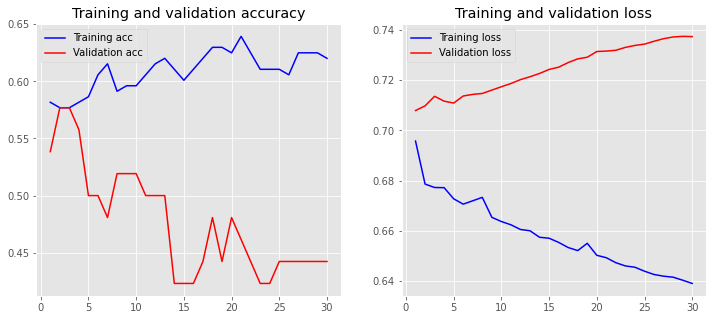

In [29]:
plot_history(history)